# Inspect masks
## Generated Masks from raw Data

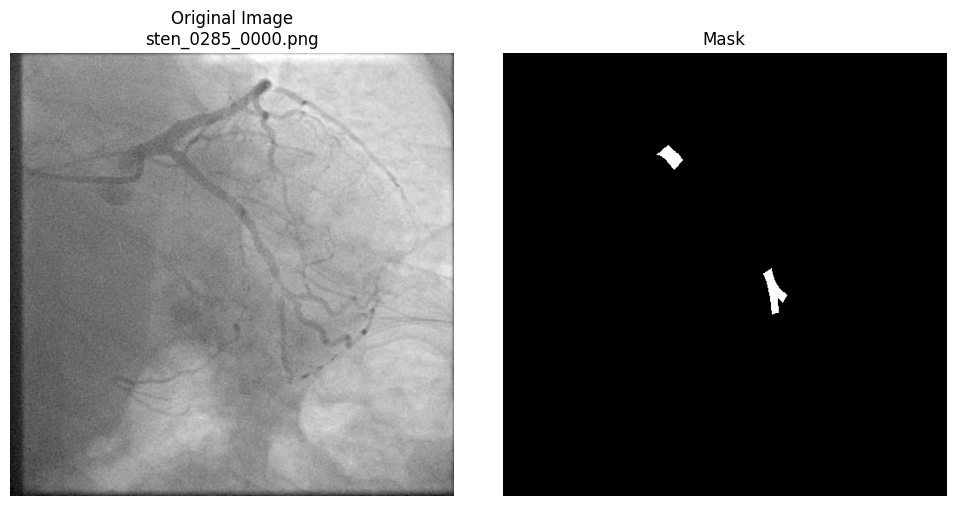

In [92]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define paths
data_root = "../nnNet_training/Raw_data/Dataset_train_val"
image_dir = os.path.join(data_root, "imagesTr")
mask_dir = os.path.join(data_root, "labelsTr")

def load_random_image_and_mask():
    """Loads a random image and its corresponding mask."""
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
    if not image_files:
        print("No images found.")
        return None, None, None
    
    random_image = random.choice(image_files)
    image_path = os.path.join(image_dir, random_image)
    mask_filename = random_image.replace("_0000.png", ".png")  # Ensure correct mapping
    mask_path = os.path.join(mask_dir, mask_filename)
    
    if not os.path.exists(mask_path):
        print(f"Mask not found for {random_image}")
        return None, None, None
    
    return Image.open(image_path), Image.open(mask_path), random_image

def visualize_image_and_mask():
    """Plots a random image and its corresponding mask."""
    image, mask, filename = load_random_image_and_mask()
    
    if image is None or mask is None:
        print("Could not load image and mask.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap="gray" if image.mode == "L" else None)
    axes[0].set_title(f"Original Image\n{filename}")
    axes[0].axis("off")
    
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_image_and_mask()

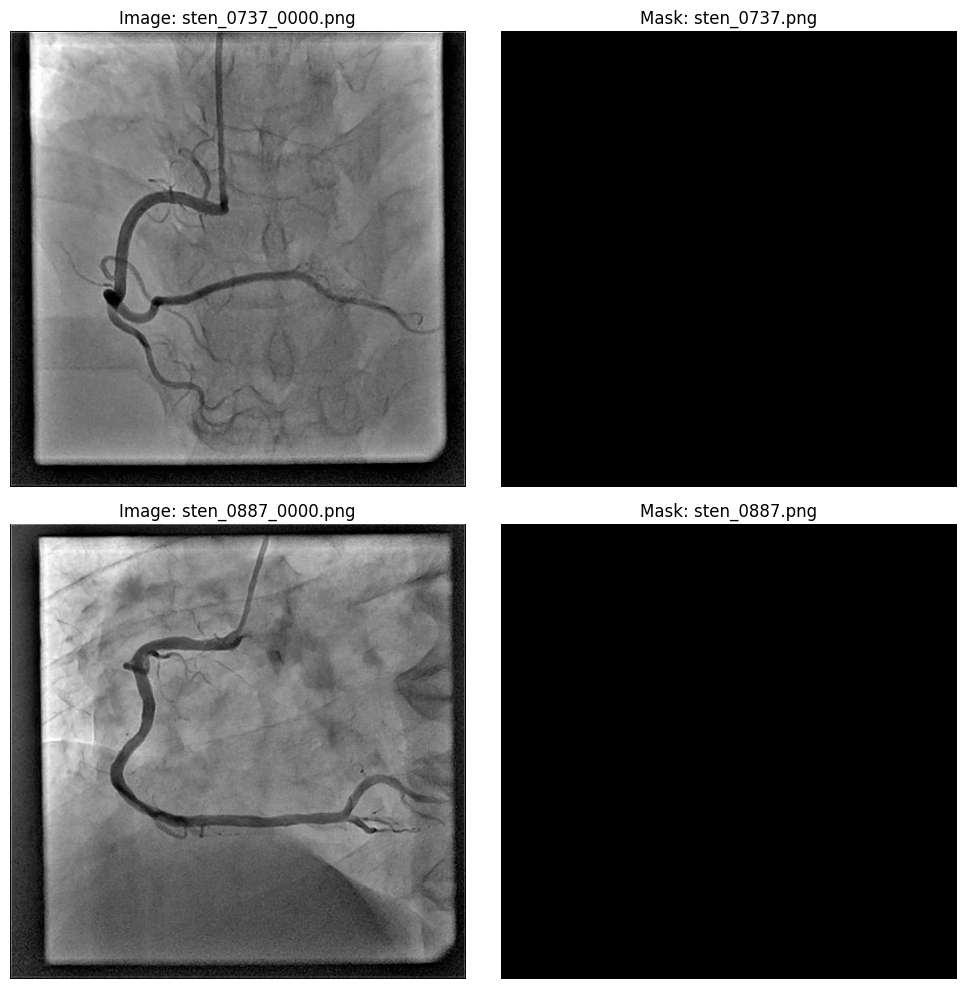

In [133]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Paths for images and masks
image_paths = [
    "../nnNet_training/Raw_data/Dataset_Train_val/imagesTr/sten_0737_0000.png",
    "../nnNet_training/Raw_data/Dataset_Train_val/imagesTr/sten_0887_0000.png"
]

mask_paths = [
    "../nnNet_training/Raw_data/Dataset_Train_val/labelsTr/sten_0737.png",
    "../nnNet_training/Raw_data/Dataset_Train_val/labelsTr/sten_0887.png"
    ]

def load_image(image_path):
    """Load an image if it exists, otherwise return None."""
    if os.path.exists(image_path):
        return Image.open(image_path)
    return None

# Plot images and masks
num_images = len(image_paths)
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
    img = load_image(img_path)
    mask = load_image(mask_path)

    # Plot Image
    axes[i, 0].axis("off")
    if img:
        axes[i, 0].imshow(img, cmap="gray" if img.mode == "L" else None)
        axes[i, 0].set_title(f"Image: {os.path.basename(img_path)}")
    else:
        axes[i, 0].text(0.5, 0.5, "Image Not Found", color="red", fontsize=12, ha="center")
        axes[i, 0].set_title(f"Missing Image: {os.path.basename(img_path)}")

    # Plot Mask
    axes[i, 1].axis("off")
    if mask:
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title(f"Mask: {os.path.basename(mask_path)}")
    else:
        axes[i, 1].text(0.5, 0.5, "Mask Not Found", color="red", fontsize=12, ha="center")
        axes[i, 1].set_title(f"Missing Mask: {os.path.basename(mask_path)}")

plt.tight_layout()
plt.show()

## Comaparison GT Segmentation and manually generated Masks

In [96]:
path_gt = "../nnNet_training/nnUNet_preprocessed/Dataset_Train_val/gt_segmentations/"
path_lables = "../nnNet_training/Raw_data/Dataset_Train_val/labelsTr/"

# Load mask
mask = Image.open(os.path.join(path_gt, "sten_0000.png"))
mask1 = Image.open(os.path.join(path_lables, "sten_0000.png"))

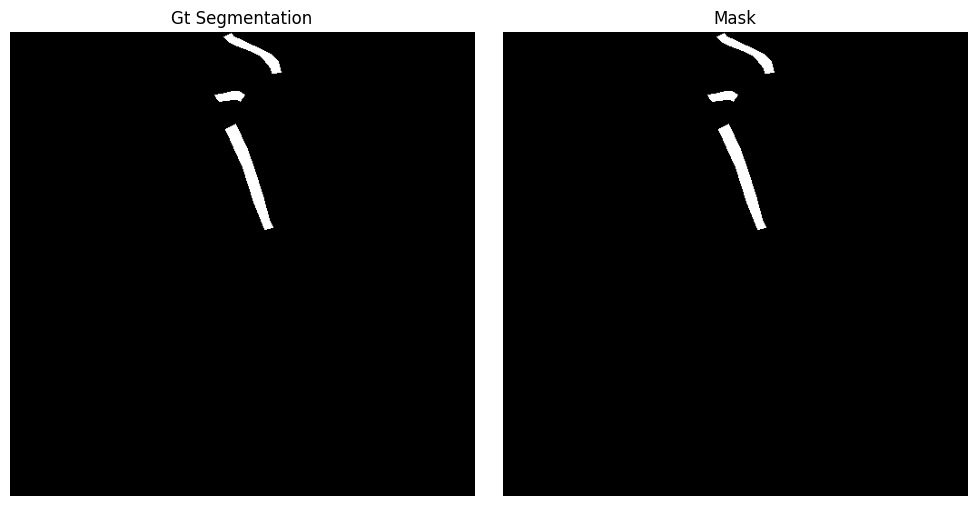

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask, cmap="gray" if mask.mode == "L" else None)
axes[0].set_title(f"Gt Segmentation")
axes[0].axis("off")

axes[1].imshow(mask1, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
path_val = "nnNet_training/nnUNet_results/Dataset_Train_val/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation/"

mask_val = Image.open(os.path.join(path_gt, "sten_0000.png"))

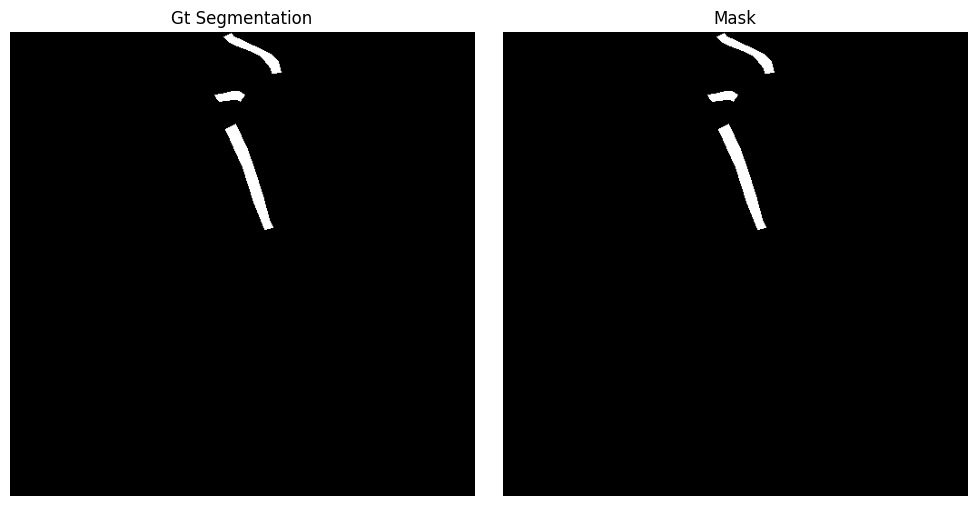

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask, cmap="gray" if mask.mode == "L" else None)
axes[0].set_title(f"Gt Segmentation")
axes[0].axis("off")

axes[1].imshow(mask_val, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Prediction and actual masks

In [112]:
path_test = "../dataset_test"
path_raw_data = "raw"
path_labels = "labels"
path_preprocessed_data = "preprocessed"
path_raw_prediction = "raw_prediction"
path_post_prediction = "post_prediction"

path_pict = "2.png"
#path_mask = "sten_0007.png"
path_path_label = "2.png"

full_raw_path = os.path.join(path_test, path_raw_data, path_pict)
full_preprocessed_path = os.path.join(path_test, path_preprocessed_data, path_pict)
#full_raw_prediction_path = os.path.join(path_test, path_raw_prediction, path_mask)
#full_post_prediction_path = os.path.join(path_test, path_post_prediction, path_mask)
full_mask_path = os.path.join(path_test, path_labels, path_path_label)


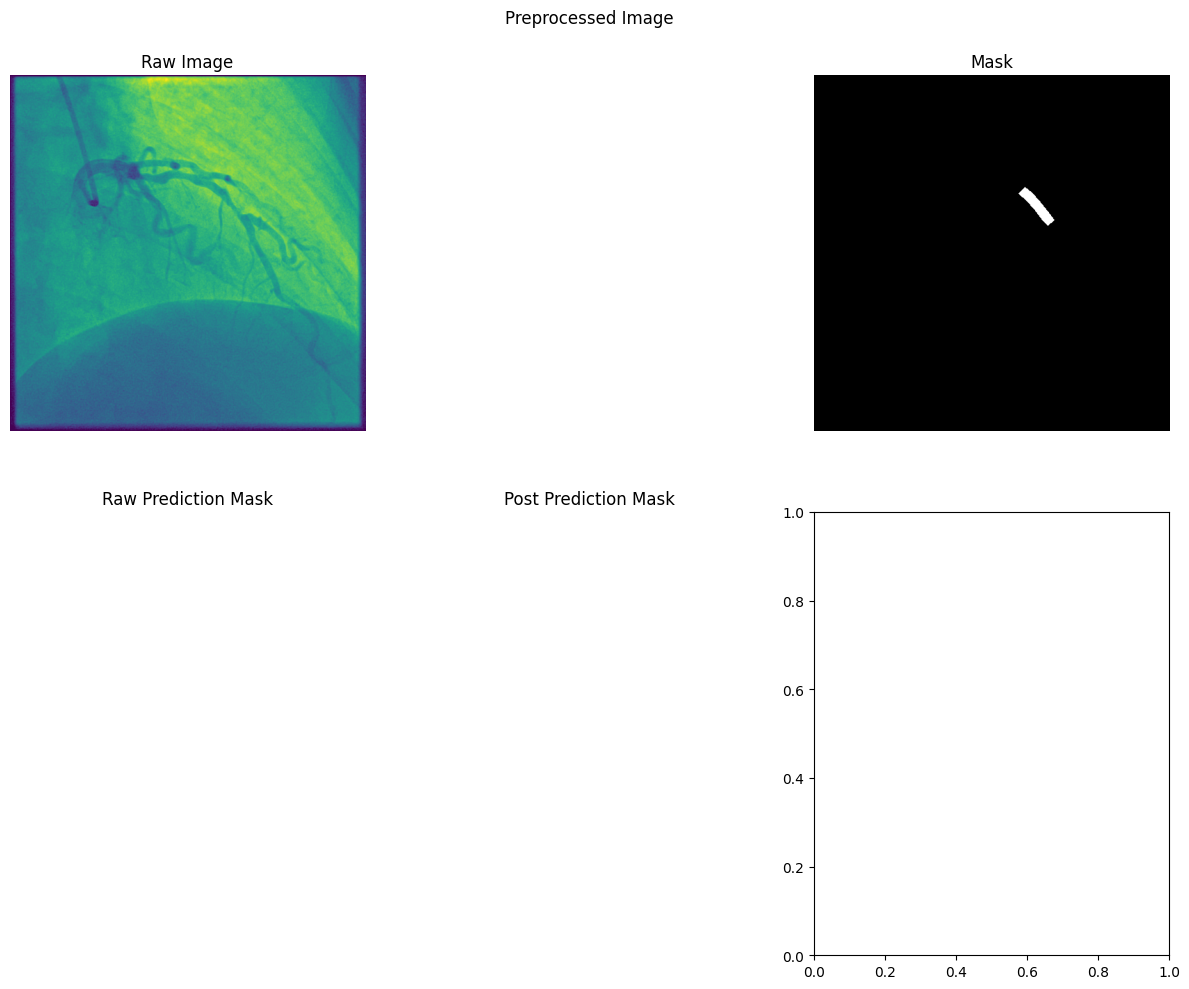

In [113]:
# Load images
raw_image = Image.open(full_raw_path)
raw_mask = Image.open(full_mask_path)
#preprocessed_image = Image.open(full_preprocessed_path)
#raw_prediction_mask = Image.open(full_raw_prediction_path).convert("L")  # Convert mask to grayscale
#post_prediction_mask = Image.open(full_post_prediction_path).convert("L")  # Convert mask to grayscale

# Create 2x2 subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Plot Raw Image
axes[0, 0].imshow(raw_image)
axes[0, 0].set_title("Raw Image")
axes[0, 0].axis("off")

# Plot Preprocessed Image
#axes[0, 1].imshow(preprocessed_image)
axes[0, 1].set_title("Preprocessed Image")
axes[0, 1].axis("off")

# Plotq Mask
axes[0, 2].imshow(raw_mask, cmap="gray")
axes[0, 2].set_title("Mask")
axes[0, 2].axis("off")

# Plot Raw Prediction Mask
#axes[1, 0].imshow(raw_prediction_mask, cmap="gray")
axes[1, 0].set_title("Raw Prediction Mask")
axes[1, 0].axis("off")

# Plot Post Prediction Mask
#axes[1, 1].imshow(post_prediction_mask, cmap="gray")
axes[1, 1].set_title("Post Prediction Mask")
axes[1, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()